In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

In [2]:
# Constant definitions
REVIEW_FILE = "Grocery_and_Gourmet_Food.json"
REVIEW_PICKLE = "reviews"
META_FILE = "meta_Grocery_and_Gourmet_Food.json"
META_PICKLE = "meta"
DATA_LOCATION = "data/"
PICKLE_LOCATION = "processed-data/"

In [3]:
def load_pickle(pickle_name):
    with open(PICKLE_LOCATION+pickle_name, 'rb') as file:
        return pickle.load(file)

In [4]:
def save_pickle(result, pickle_name):
    with open(PICKLE_LOCATION+pickle_name, 'wb') as file:
        pickle.dump(result, file)

In [5]:
def read_file(file):
    if file == REVIEW_FILE:
        pickle_name = REVIEW_PICKLE
    elif file == META_FILE:
        pickle_name = META_PICKLE
    else:
        pickle_name = file
    
    try:
        return load_pickle(pickle_name)
    except (FileNotFoundError, EOFError) as e:
        file_df = pd.read_json(DATA_LOCATION+file, lines=True)
        save_pickle(file_df, pickle_name)
        return file_df

In [6]:
def format_reviews(reviews):
    reviews["overall"] = reviews["overall"].astype(int)
    reviews["verified"] = reviews["verified"].astype(bool)
    
    # Cast reviewTime to date
    reviews["reviewTime"] = reviews["reviewTime"].str.replace("^0", "")
    reviews["reviewTime"] = pd.to_datetime(reviews["reviewTime"], format="%m %d, %Y")
    
    # Cast vote to int, while changing NaN values to 0
    #reviews.loc[reviews["vote"].isnull(), "vote"] = "0"
    reviews["vote"] = reviews["vote"].str.replace(",", "") # Thousands are separated with commas, we remove them. e.g. 1,881 = 1881
    reviews["vote"].fillna(0, inplace=True)
    reviews["vote"] = reviews["vote"].astype(int)
    
    # transform nan values in reviewText and summary to empty string
    reviews["reviewText"].fillna("", inplace=True)
    reviews["summary"].fillna("", inplace=True)

def format_meta(meta):
    # Not formated: also_view and also_bought, image and five last (feature, ...)
    cols_empty_string = ['description', 'title', 'main_cat', 'brand', 'rank', 'also_view', 'also_buy']
    # Fill na?
    meta.loc[:, cols_empty_string] = meta.loc[:, cols_empty_string].fillna("")
    
    # Map the list representation of category and description to string
    cols_list_to_string = ['category', 'description']
    meta.loc[:, cols_list_to_string] = meta.loc[:, cols_list_to_string].applymap(lambda l: ' '.join(l))
    
    # Verification: meta[(meta['price'].isnull()) | (meta['price'].str.contains('^\$'))].size - meta.size
    meta['price'] = pd.to_numeric(meta['price'].str.replace('$', '', regex=False), errors='coerce')
    
    # Cast date column to date format
    meta['date'] = pd.to_datetime(meta['date'], errors='coerce')

In [7]:
list()

[]

In [8]:
reviews = read_file(REVIEW_FILE)
meta = read_file(META_FILE)

In [9]:
reviews.isnull().sum()

overall                 0
verified                0
reviewTime              0
reviewerID              0
asin                    0
reviewerName          355
reviewText           2883
summary              1327
unixReviewTime          0
vote              4414688
image             5003225
style             2798836
dtype: int64

In [10]:
meta.isnull().sum()

category             0
description      35407
title                4
brand            11422
rank             11715
also_view       166197
main_cat          1493
price           155073
asin                 0
also_buy        203877
image           136995
date            277546
feature         270835
details          13886
similar_item    286953
tech1           286465
fit             287205
dtype: int64

In [11]:
meta_prices = meta["price"][meta["price"].notnull()]
meta_prices[~meta_prices.str.contains("$", regex=False)] # All prices are either NaN or $ something

Series([], Name: price, dtype: object)

In [12]:
reviews.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,image,style
0,5,True,"06 4, 2013",ALP49FBWT4I7V,1888861614,Lori,Very pleased with my purchase. Looks exactly l...,Love it,1370304000,NaN,NaN,NaN
1,4,True,"05 23, 2014",A1KPIZOCLB9FZ8,1888861614,BK Shopper,Very nicely crafted but too small. Am going to...,Nice but small,1400803200,NaN,NaN,NaN
2,4,True,"05 9, 2014",A2W0FA06IYAYQE,1888861614,daninethequeen,still very pretty and well made...i am super p...,"the ""s"" looks like a 5, kina",1399593600,NaN,NaN,NaN
3,5,True,"04 20, 2014",A2PTZTCH2QUYBC,1888861614,Tammara,"I got this for our wedding cake, and it was ev...",Would recommend this to a friend!,1397952000,NaN,NaN,NaN
4,4,True,"04 16, 2014",A2VNHGJ59N4Z90,1888861614,LaQuinta Alexander,It was just what I want to put at the top of m...,Topper,1397606400,NaN,NaN,NaN


In [13]:
meta.head()

,category,description,title,brand,rank,also_view,main_cat,price,asin,also_buy,image,date,feature,details,similar_item,tech1,fit
0,"[Grocery & Gourmet Food, Dairy, Cheese & Eggs,...","[BEEMSTER GOUDA CHEESE AGED 18/24 MONTHS, Stat...",Beemster Gouda - Aged 18/24 Months - App. 1.5 Lbs,Ariola Imports,"165,181inGroceryGourmetFood(","[B0000D9MYM, B0000D9MYL, B00ADHIGBA, B00H9OX59...",Grocery,$41.91,0681727810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[Grocery & Gourmet Food, Cooking & Baking, Sug...","[Shipped from UK, please allow 10 to 21 busine...",Trim Healthy Mama Xylitol,NaN,"315,867inGroceryGourmetFood(",NaN,Grocery,NaN,0853347867,"[B01898YHXK, B01BCM6LAC, B00Q4OL47O, B00Q4OL5Q...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN
2,"[Grocery & Gourmet Food, Cooking & Baking, Fro...",[Jazz up your cakes with a sparkling monogram ...,Letter C - Swarovski Crystal Monogram Wedding ...,Unik Occasions,">#669,941 in Kitchen & Dining (See Top 100 in ...",[B07DXN65TF],Amazon Home,$29.95,1888861118,NaN,NaN,"September 21, 2010",NaN,NaN,NaN,NaN,NaN
3,"[Grocery & Gourmet Food, Cooking & Baking, Fro...","[Large Letter - Height 4.75""]",Letter H - Swarovski Crystal Monogram Wedding ...,Other,">#832,581 in Kitchen & Dining (See Top 100 in ...",NaN,Amazon Home,$11.45,1888861517,NaN,NaN,"September 11, 2011","[Large Letter - Height 4.75""]",NaN,NaN,NaN,NaN
4,"[Grocery & Gourmet Food, Cooking & Baking, Fro...","[4.75""]",Letter S - Swarovski Crystal Monogram Wedding ...,Unik Occasions,">#590,999 in Kitchen & Dining (See Top 100 in ...",NaN,Amazon Home,$15.00,1888861614,NaN,NaN,"September 11, 2011","[4.75"" height]",NaN,NaN,NaN,NaN


In [14]:
format_reviews(reviews)
format_meta(meta)

In [18]:
reviews.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,image,style
0,5,True,2013-06-04,ALP49FBWT4I7V,1888861614,Lori,Very pleased with my purchase. Looks exactly l...,Love it,1370304000,0,NaN,NaN
1,4,True,2014-05-23,A1KPIZOCLB9FZ8,1888861614,BK Shopper,Very nicely crafted but too small. Am going to...,Nice but small,1400803200,0,NaN,NaN
2,4,True,2014-05-09,A2W0FA06IYAYQE,1888861614,daninethequeen,still very pretty and well made...i am super p...,"the ""s"" looks like a 5, kina",1399593600,0,NaN,NaN
3,5,True,2014-04-20,A2PTZTCH2QUYBC,1888861614,Tammara,"I got this for our wedding cake, and it was ev...",Would recommend this to a friend!,1397952000,0,NaN,NaN
4,4,True,2014-04-16,A2VNHGJ59N4Z90,1888861614,LaQuinta Alexander,It was just what I want to put at the top of m...,Topper,1397606400,0,NaN,NaN


In [17]:
meta.isnull().sum()

category             0
description          0
title                0
brand                0
rank                 0
also_view            0
main_cat             0
price           155184
asin                 0
also_buy             0
image           136995
date            277650
feature         270835
details          13886
similar_item    286953
tech1           286465
fit             287205
dtype: int64

In [19]:
meta.head()

,category,description,title,brand,rank,also_view,main_cat,price,asin,also_buy,image,date,feature,details,similar_item,tech1,fit
0,"Grocery & Gourmet Food Dairy, Cheese & Eggs Ch...",BEEMSTER GOUDA CHEESE AGED 18/24 MONTHS Statem...,Beemster Gouda - Aged 18/24 Months - App. 1.5 Lbs,Ariola Imports,"165,181inGroceryGourmetFood(","[B0000D9MYM, B0000D9MYL, B00ADHIGBA, B00H9OX59...",Grocery,41.91,0681727810,,NaN,NaT,NaN,NaN,NaN,NaN,NaN
1,Grocery & Gourmet Food Cooking & Baking Sugar ...,"Shipped from UK, please allow 10 to 21 busines...",Trim Healthy Mama Xylitol,,"315,867inGroceryGourmetFood(",,Grocery,NaN,0853347867,"[B01898YHXK, B01BCM6LAC, B00Q4OL47O, B00Q4OL5Q...",[https://images-na.ssl-images-amazon.com/image...,NaT,NaN,NaN,NaN,NaN,NaN
2,Grocery & Gourmet Food Cooking & Baking Frosti...,Jazz up your cakes with a sparkling monogram f...,Letter C - Swarovski Crystal Monogram Wedding ...,Unik Occasions,">#669,941 in Kitchen & Dining (See Top 100 in ...",[B07DXN65TF],Amazon Home,29.95,1888861118,,NaN,2010-09-21,NaN,NaN,NaN,NaN,NaN
3,Grocery & Gourmet Food Cooking & Baking Frosti...,"Large Letter - Height 4.75""",Letter H - Swarovski Crystal Monogram Wedding ...,Other,">#832,581 in Kitchen & Dining (See Top 100 in ...",,Amazon Home,11.45,1888861517,,NaN,2011-09-11,"[Large Letter - Height 4.75""]",NaN,NaN,NaN,NaN
4,Grocery & Gourmet Food Cooking & Baking Frosti...,"4.75""",Letter S - Swarovski Crystal Monogram Wedding ...,Unik Occasions,">#590,999 in Kitchen & Dining (See Top 100 in ...",,Amazon Home,15.00,1888861614,,NaN,2011-09-11,"[4.75"" height]",NaN,NaN,NaN,NaN


In [54]:
month_upvote = reviews[['vote']].copy()
months = reviews['reviewTime'].map(lambda date: date.month)
years = reviews['reviewTime'].map(lambda date: date.year)
month_upvote['month'] = months
month_upvote['year'] = years
month_score = reviews[['overall']].copy()
month_score['month'] = months
month_score['year'] = years

In [59]:
month_upvote_filter = month_upvote[month_upvote['year'] == 2018]
month_score_filter = month_score[month_score['year'] == 2018]

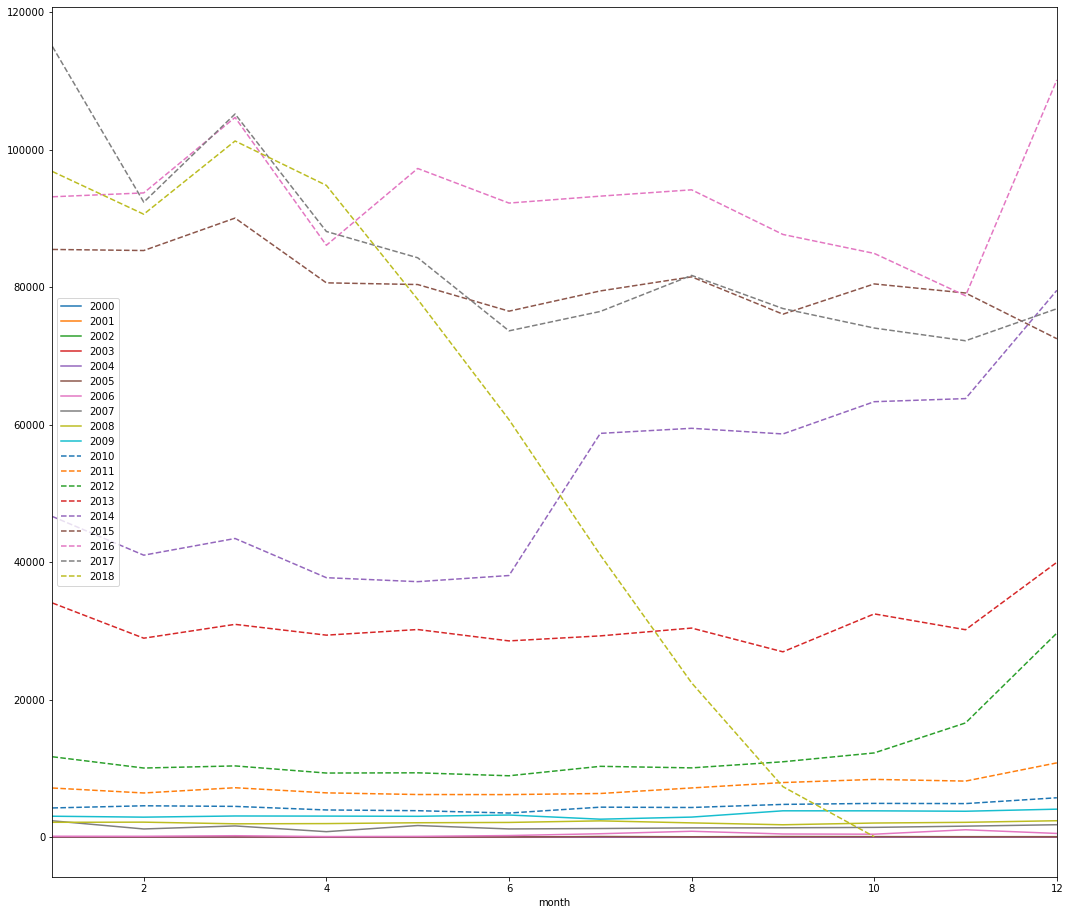

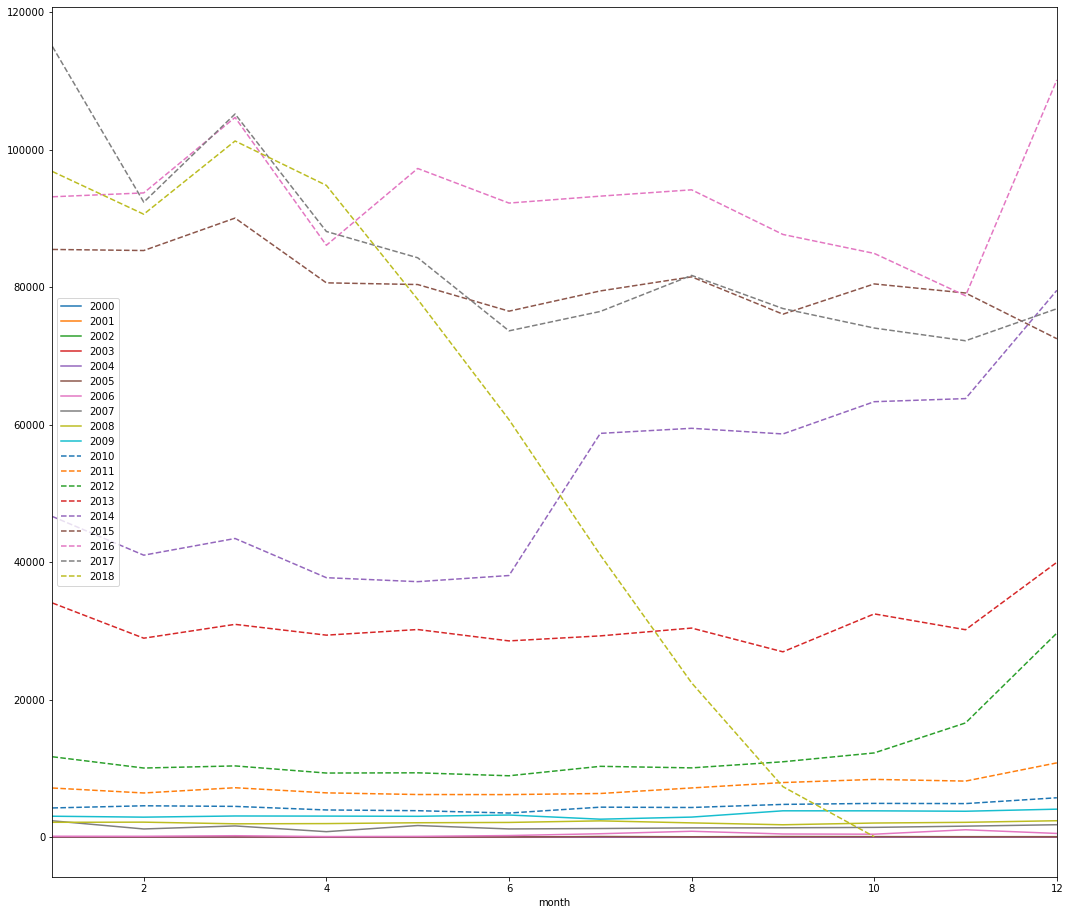

In [77]:
years = month_score['year'].unique()


for year in sorted(years):
    if year >= 2010:
        linestyle='--'
    else:
        linestyle='-'
    month_upvote_filter = month_upvote[month_upvote['year'] == year]
    month_vote_grouped = month_upvote_filter.groupby('month')['vote'].count()
    month_vote_grouped.plot(label=str(year), figsize=(18,16), linestyle=linestyle)
plt.legend()
plt.show()

for year in sorted(years):
    if year >= 2010:
        linestyle='--'
    else:
        linestyle='-'
    month_score_filter = month_score[month_score['year'] == year]
    month_score_grouped = month_score_filter.groupby('month')['overall'].count()
    month_score_grouped.plot(label=str(year), figsize=(18,16), linestyle=linestyle)
plt.legend()
plt.show()

In [91]:
from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure
output_notebook()

Loading BokehJS ...

In [102]:
scores = reviews[['reviewTime', 'overall']].copy()
scores['reviewTime'] = scores['reviewTime'].map(lambda date: 100*date.year + date.month)
scores = pd.DataFrame(scores.groupby('reviewTime')['overall'].count())
display(scores)
source = ColumnDataSource(scores)
p = figure(x_axis_type="datetime", plot_width=800, plot_height=350, tools=tools)
p.line('reviewTime', 'overall', source=source)
show(p)

,overall
reviewTime,
200006,1
200008,1
200012,1
200103,1
200107,1
...,...
201806,60734
201807,41051
201808,22458


In [90]:
tools = "hover, box_zoom, undo, crosshair, xwheel_zoom"
p = figure(tools=tools)
p.vbar(["Test", 2, 3], 1, [1, 2, 3])
show(p)

In [17]:
meta['category'] = meta['category'].map(lambda l: ' '.join(l))

In [18]:
meta['category']

0         Grocery & Gourmet Food Dairy, Cheese & Eggs Ch...
1         Grocery & Gourmet Food Cooking & Baking Sugar ...
2         Grocery & Gourmet Food Cooking & Baking Frosti...
3         Grocery & Gourmet Food Cooking & Baking Frosti...
4         Grocery & Gourmet Food Cooking & Baking Frosti...
                                ...                        
287204    Grocery & Gourmet Food Jams, Jellies & Sweet S...
287205    Grocery & Gourmet Food Condiments & Salad Dres...
287206    Grocery & Gourmet Food Condiments & Salad Dres...
287207    Grocery & Gourmet Food Herbs, Spices & Seasoni...
287208    Grocery & Gourmet Food Beverages Bottled Bever...
Name: category, Length: 287209, dtype: object

In [23]:
md = meta['description'].copy()
md.fillna("").map(lambda l: ' '.join(l))

0         BEEMSTER GOUDA CHEESE AGED 18/24 MONTHS Statem...
1         Shipped from UK, please allow 10 to 21 busines...
2         Jazz up your cakes with a sparkling monogram f...
3                               Large Letter - Height 4.75"
4                                                     4.75"
                                ...                        
287204    Caffarel fruit jellies are a product of Italy....
287205    Hampton Creeks Just Mayo Truffle makes fancy f...
287206    Nothing compares with the classically zesty fl...
287207                                                     
287208    McClures Spicy Bloody Mary Mix Pickles, 32 Oun...
Name: description, Length: 287209, dtype: object

In [33]:
meta.describe()

,price
count,132025.000000
mean,25.238077
std,30.594910
min,0.010000
25%,10.880000
50%,17.980000
75%,29.990000
max,999.990000


In [21]:
reviews.head().isnull()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,image,style
0,False,False,False,False,False,False,False,False,False,False,True,True
1,False,False,False,False,False,False,False,False,False,False,True,True
2,False,False,False,False,False,False,False,False,False,False,True,True
3,False,False,False,False,False,False,False,False,False,False,True,True
4,False,False,False,False,False,False,False,False,False,False,True,True


In [22]:
reviews.describe()

,overall,unixReviewTime,vote
count,5.074160e+06,5.074160e+06,5.074160e+06
mean,4.314708e+00,1.446592e+09,8.295479e-01
std,1.249303e+00,6.227839e+07,1.206719e+01
min,1.000000e+00,9.613728e+08,0.000000e+00
25%,4.000000e+00,1.416096e+09,0.000000e+00
50%,5.000000e+00,1.456790e+09,0.000000e+00
75%,5.000000e+00,1.491782e+09,0.000000e+00
max,5.000000e+00,1.538870e+09,1.217400e+04


In [53]:
reviews[["summary", "reviewText"]]

,summary,reviewText
0,Love it,Very pleased with my purchase. Looks exactly l...
1,Nice but small,Very nicely crafted but too small. Am going to...
2,"the ""s"" looks like a 5, kina",still very pretty and well made...i am super p...
3,Would recommend this to a friend!,"I got this for our wedding cake, and it was ev..."
4,Topper,It was just what I want to put at the top of m...
...,...,...
5074155,Exceclent product,"Love this product, very fresh, complete full f..."
5074156,Good taste but small quantity for the price us...,Good taste but small quantity for the expensiv...
5074157,See Comments below,Unlike some of the bad reviews regarding aroma...
5074158,Love!!,I absolutely love this vanilla bean paste. I h...


**Lemmtization of the reviewText for analysis**

In [86]:
import string
import nltk
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

lemmatizer = WordNetLemmatizer()
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger');

def remove_punctuation(s):
    punct_chars = string.punctuation
    translator_punct = s.maketrans(punct_chars, ' ' * len(punct_chars))
    
    return s.translate(translator_punct)

def remove_stopwords(s):
    stopwords_np = np.array(stopwords.words('english'))
    words = np.array(s.split())
    words_filtered = words[~np.in1d(words, stopwords_np)]
    
    return ' '.join(words_filtered)

def transform_tag(tag):
    tag_prefix = tag[0].lower()
    if tag_prefix in ['n', 'r', 'v', 'j']:
        return 'a' if tag_prefix == 'j' else tag_prefix
    else:
        return 'n'

def lemmatize(t):
    t = remove_punctuation(t)
    t = remove_stopwords(t)
    t_token = word_tokenize(t)
    t_tags = pos_tag(t_token)
    print(t_tags)
    t_lemm = [lemmatizer.lemmatize(w, transform_tag(t)) for w, t in t_tags]
    return ' '.join(t_lemm)

[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [Errno -3] Temporary failure in name resolution>


In [87]:
print('Example of lemmatizing pipeline')
testpd = pd.DataFrame(np.array([['I tried to stop some words to see  the lemmatizing. \nWords word!! alias-alias to and'], 
                                ['Here we\'ll see.']]), columns=['raw'])
testpd['lemmatized'] = testpd['raw'].apply(lemmatize)
testpd

Example of lemmatizing pipeline
[('I', 'PRP'), ('tried', 'VBD'), ('stop', 'JJ'), ('words', 'NNS'), ('see', 'VBP'), ('lemmatizing', 'JJ'), ('Words', 'NNP'), ('word', 'NN'), ('alias', 'NN'), ('alias', 'NN')]
[('Here', 'RB'), ('see', 'VB')]


,raw,lemmatized
0,I tried to stop some words to see the lemmati...,I try stop word see lemmatizing Words word ali...
1,Here we'll see.,Here see


In [ ]:
# Very slow, didn't run yet
reviews["reviewTextLemma"] = reviews['reviewText'].apply(lemmatize)
reviews